In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

import matplotlib.pyplot as plt

### Playground

#### Our implementation

In [83]:
class TimeEmbedding(nn.Module):

    def __init__(self, dim=64, time_channels=256):
        super().__init__()

        self.dim = dim
        self.time_channels = time_channels

        # argument to sin/cos fn: t / 10000^(i / d) where i = 2k or 2k + 1 - https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
        self.factor = torch.exp(torch.arange(0, self.dim, 2) * (- torch.log(torch.tensor(10000.0)) / self.dim))
        

    def forward(self, t):

        # if t = tensor.torch(int), t.shape = []
        # change it so that t.shape = [1]
        if len(t.shape) == 0:
          t = t.unsqueeze(0)

        t = t.unsqueeze(1) * self.factor

        # shape of embedding [time_channels, dim]
        emb = torch.zeros(self.time_channels, self.dim)
        emb[:, 0::2] = torch.sin(t)
        emb[:, 1::2] = torch.cos(t)

        return emb

t_emb.shape:  torch.Size([256, 64])


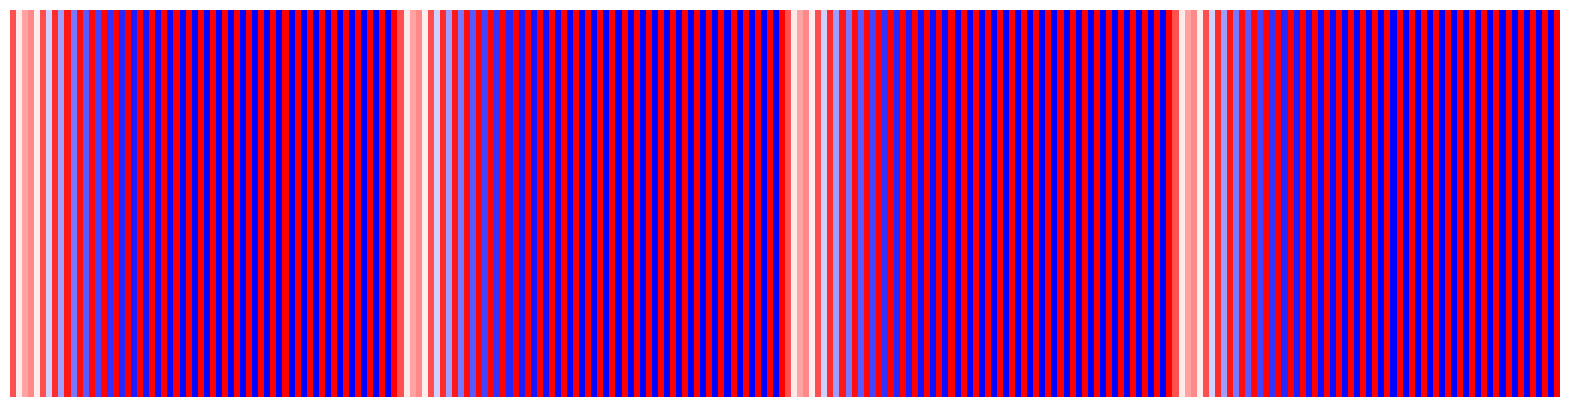

In [85]:
time_emb = TimeEmbedding(dim=64, time_channels=256)
t = torch.tensor(1)
t_emb = time_emb(t)
print('t_emb.shape: ', t_emb.shape)
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

ax.imshow(t_emb.detach().numpy().reshape(t_emb.shape[1], t_emb.shape[0]), cmap='bwr', interpolation='nearest')

#### breaking it down

* dim - specifies the dimensionality of the time embedding

In [ ]:
dim = 64 # same as the labml implementation

* factor is the multiplicative factor inside the sin()/cos() -

\begin{align}
        f(t)^{(i)} = \left\{
        \begin{array}{cl}
        sin(w_t ⋅ t) & i = 2k \\
        cos(w_t ⋅ t) & i = 2k + 1.
        \end{array}
        \right.
\end{align}

where 

\begin{align}
  w_t = \frac{1}{10000^\frac{2k}{d}}
\end{align}

* some maths -
\begin{align}
  e^{- k  * l} 
  = \frac{1}{e^{k * l}}\\
  = \frac{1}{e^{k * \frac{ln(10000)}{d}}} \\
  = \frac{1}{e^{ln(10000)^\frac{k}{d}}} \\
  = \frac{1}{10000^\frac{k}{d}}
\end{align}

where k is the vector of indexes (2k in the function definition)

In [54]:
k = torch.arange(0, dim, 2)
print('k.shape: ', k.shape)
print('k: ', k.data)

l = - torch.log(torch.tensor(10000.0)) / dim
print('\nl: ', l.data)

w_t = torch.exp(k * l)
print('\nw_t.shape: ', w_t.shape)
print('w_t: ', w_t.data)

k.shape:  torch.Size([32])
k:  tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62])

l:  tensor(-0.1439)

w_t.shape:  torch.Size([32])
w_t:  tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04])


Note that the length of the tensor (32) is half the dimension (64)

In [58]:
factor = w_t

For a time step t (an integer), convert it to a tensor

In [61]:
i = 1
t = torch.tensor(i)
print('t.shape: ', t.shape)
print('t: ', t.data)

t.shape:  torch.Size([])
t:  tensor(1)


Reshape the 0-dim tensor to 1-d

In [62]:
if len(t.shape) == 0:
  t = t.unsqueeze(0)
print('t.shape: ', t.shape)
print('t: ', t.data)

t.shape:  torch.Size([1])
t:  tensor([1])


Multiply the time tensor with the multiplicative factor (w_t)

In [63]:
t = t.unsqueeze(1) * factor
print('t.shape: ', t.shape)
print('t: ', t.data)

t.shape:  torch.Size([1, 32])
t:  tensor([[1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
         1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
         3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
         5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
         1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
         1.7783e-04, 1.3335e-04]])


Create a new tensor to hold the embedding
* time_channels - specifies the number of channels each embedding should have. Labml implementation uses 256 time_channels. For illustrative purposes, here we use 1. Later visualizations consider 256 time_channels.

In [65]:
time_channels = 1
emb = torch.zeros(time_channels, dim)
print('emb.shape: ', emb.shape)

emb.shape:  torch.Size([1, 64])


Create the embedding according to the formula -
\begin{align}
        f(t)^{(i)} = \left\{
        \begin{array}{cl}
        sin(w_t ⋅ t) & i = 2k \\
        cos(w_t ⋅ t) & i = 2k + 1.
        \end{array}
        \right.
\end{align}

* Even indexes will get sin(), odd indexes will get cos()

In [66]:
emb[:, 0::2] = torch.sin(t)
emb[:, 1::2] = torch.cos(t)
print('emb.shape: ', emb.shape)
print('emb: ', emb.data)

emb.shape:  torch.Size([1, 64])
emb:  tensor([[8.4147e-01, 5.4030e-01, 6.8156e-01, 7.3176e-01, 5.3317e-01, 8.4601e-01,
         4.0931e-01, 9.1240e-01, 3.1098e-01, 9.5042e-01, 2.3492e-01, 9.7201e-01,
         1.7689e-01, 9.8423e-01, 1.3296e-01, 9.9112e-01, 9.9833e-02, 9.9500e-01,
         7.4919e-02, 9.9719e-01, 5.6204e-02, 9.9842e-01, 4.2157e-02, 9.9911e-01,
         3.1618e-02, 9.9950e-01, 2.3712e-02, 9.9972e-01, 1.7782e-02, 9.9984e-01,
         1.3335e-02, 9.9991e-01, 9.9998e-03, 9.9995e-01, 7.4989e-03, 9.9997e-01,
         5.6234e-03, 9.9998e-01, 4.2170e-03, 9.9999e-01, 3.1623e-03, 9.9999e-01,
         2.3714e-03, 1.0000e+00, 1.7783e-03, 1.0000e+00, 1.3335e-03, 1.0000e+00,
         1.0000e-03, 1.0000e+00, 7.4989e-04, 1.0000e+00, 5.6234e-04, 1.0000e+00,
         4.2170e-04, 1.0000e+00, 3.1623e-04, 1.0000e+00, 2.3714e-04, 1.0000e+00,
         1.7783e-04, 1.0000e+00, 1.3335e-04, 1.0000e+00]])


Visualization of the time embedding for time step 1

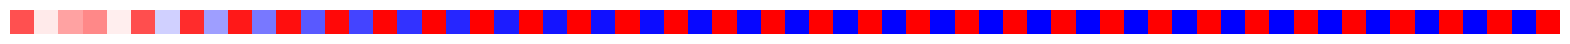

In [67]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

ax.imshow(emb.detach().numpy(), cmap='bwr', interpolation='nearest')

The above idea applied to 100 time steps. Each row of the output embedding list corresponds to a time embedding - a single-channel embedding in 64-D space.

embedding shape:  torch.Size([1, 64])
torch.Size([100, 64])


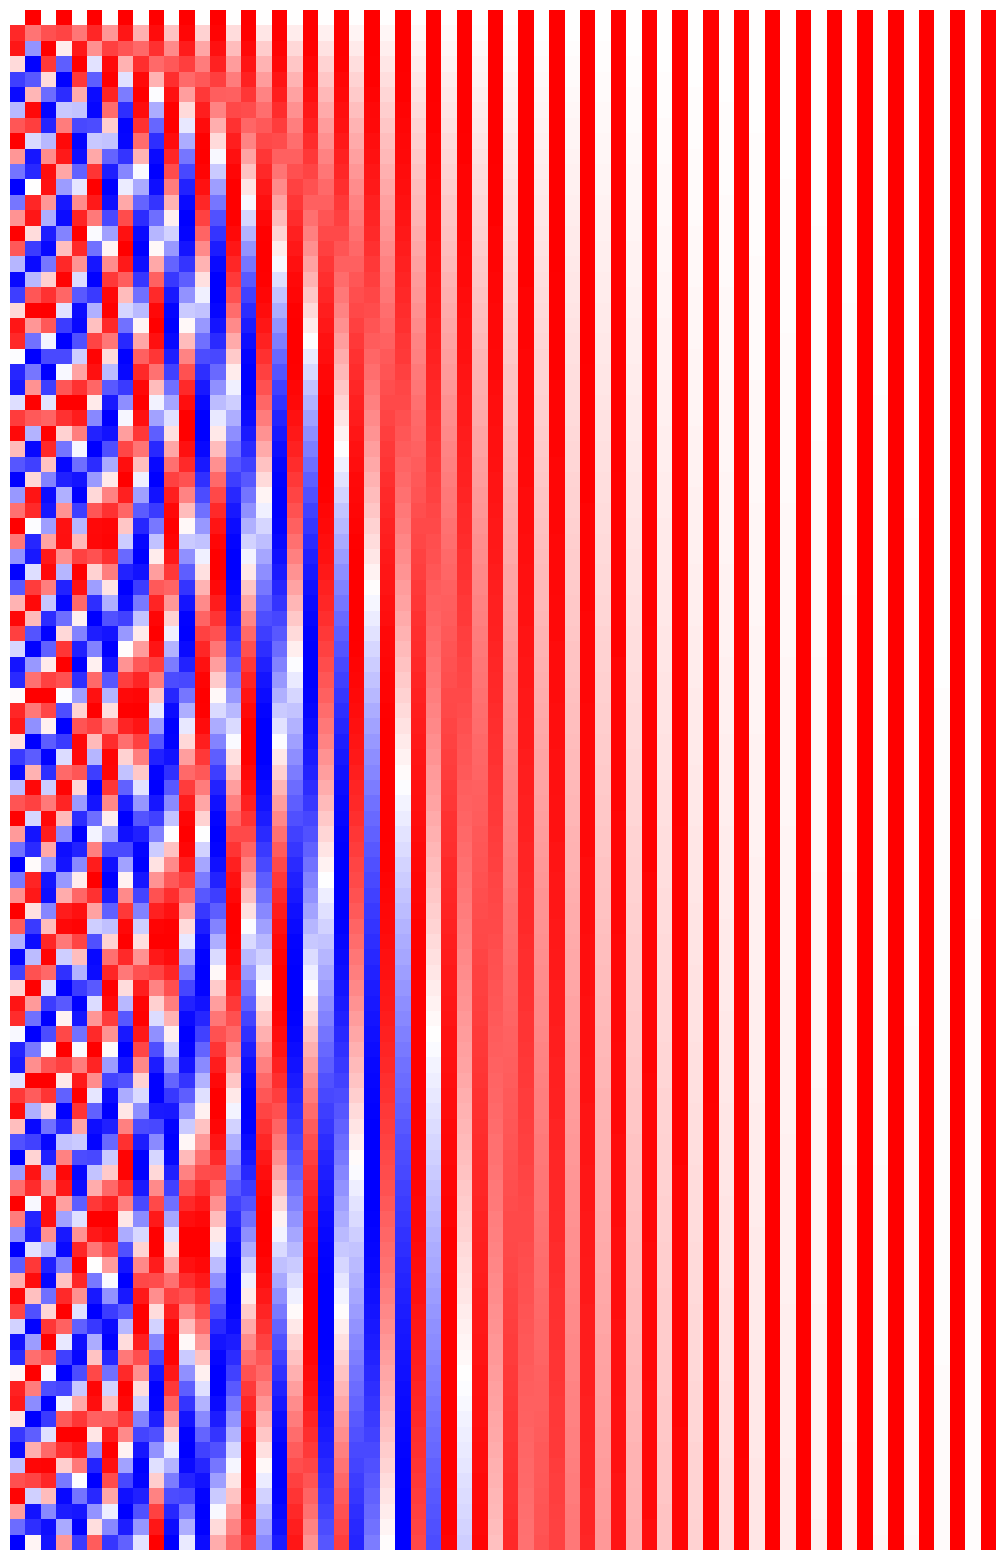

In [69]:
dim = 64
time_channels = 1
emb_list = torch.empty((0,dim))
factor = torch.exp(torch.arange(0, dim, 2) * (- torch.log(torch.tensor(10000.0)) / dim))

for i in range(100):

  t = torch.tensor(i)

  if len(t.shape) == 0:
    t = t.unsqueeze(0)

  t = t.unsqueeze(1) * factor

  emb = torch.zeros(time_channels, dim)
  emb[:, 0::2] = torch.sin(t)
  emb[:, 1::2] = torch.cos(t)
  emb_list = torch.cat((emb_list, emb), dim=0)

print('embedding shape: ', emb.shape)
print(emb_list.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')
#ax.imshow(emb_list.detach().numpy().reshape(emb_list.shape[1], emb_list.shape[0]), cmap='bwr', interpolation='nearest')

With 256 time channels (and 5 time steps) - each row of the output embedding list corresponds to a time embedding - a 256-channel embedding in 64-D space.

embedding shape:  torch.Size([256, 64])
torch.Size([1280, 64])


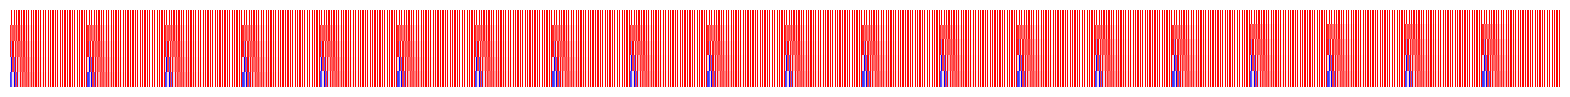

In [73]:
dim = 64
time_channels = 256
emb_list = torch.empty((0,dim))
factor = torch.exp(torch.arange(0, dim, 2) * (- torch.log(torch.tensor(10000.0)) / dim))

for i in range(5):

  t = torch.tensor(i)

  if len(t.shape) == 0:
    t = t.unsqueeze(0)

  t = t.unsqueeze(1) * factor

  emb = torch.zeros(time_channels, dim)
  emb[:, 0::2] = torch.sin(t)
  emb[:, 1::2] = torch.cos(t)
  emb_list = torch.cat((emb_list, emb), dim=0)

print('embedding shape: ', emb.shape)
print(emb_list.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

#ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')
ax.imshow(emb_list.detach().numpy().reshape(emb_list.shape[1], emb_list.shape[0]), cmap='bwr', interpolation='nearest')

For time step 1

embedding shape:  torch.Size([256, 64])


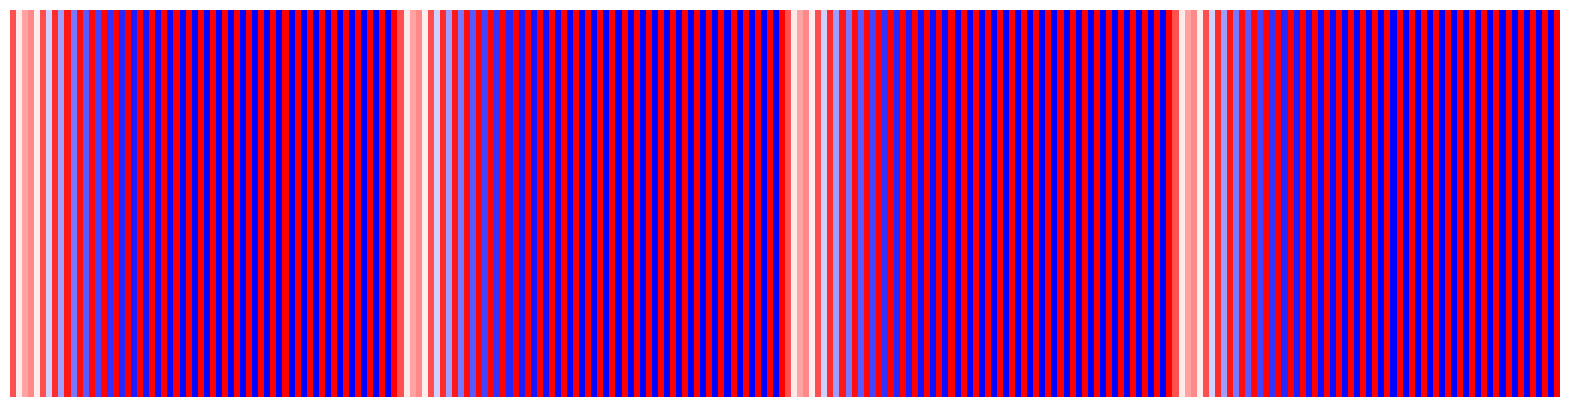

In [76]:
dim = 64
time_channels = 256
factor = torch.exp(torch.arange(0, dim, 2) * (- torch.log(torch.tensor(10000.0)) / dim))


t = torch.tensor(1)

if len(t.shape) == 0:
  t = t.unsqueeze(0)

t = t.unsqueeze(1) * factor

emb = torch.zeros(time_channels, dim)
emb[:, 0::2] = torch.sin(t)
emb[:, 1::2] = torch.cos(t)

print('embedding shape: ', emb.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

#ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')
ax.imshow(emb.detach().numpy().reshape(emb.shape[1], emb.shape[0]), cmap='bwr', interpolation='nearest')

For time step 2

embedding shape:  torch.Size([256, 64])


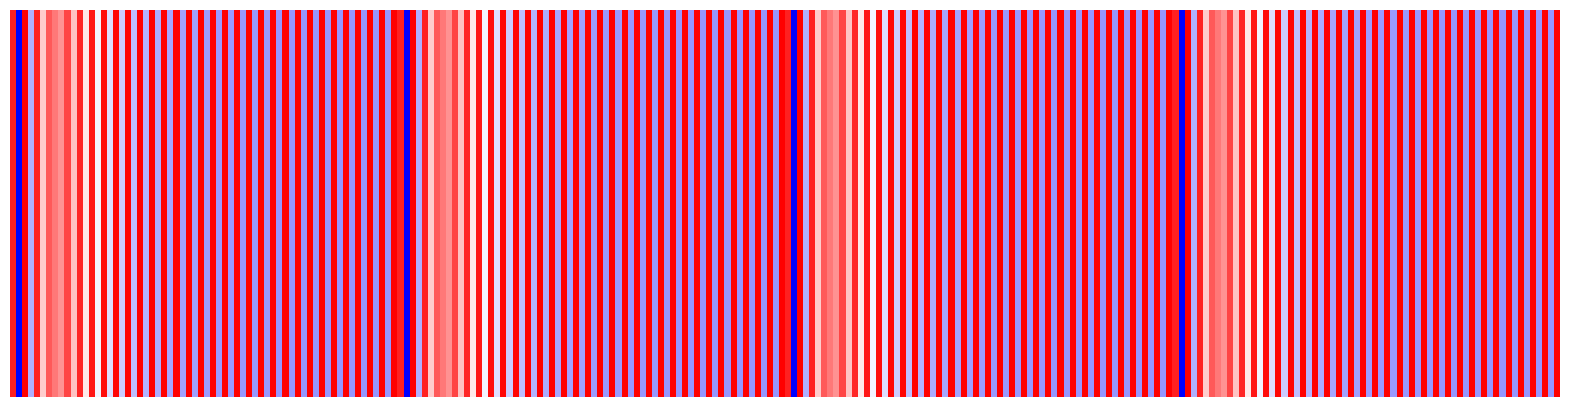

In [77]:
dim = 64
time_channels = 256
factor = torch.exp(torch.arange(0, dim, 2) * (- torch.log(torch.tensor(10000.0)) / dim))


t = torch.tensor(2)

if len(t.shape) == 0:
  t = t.unsqueeze(0)

t = t.unsqueeze(1) * factor

emb = torch.zeros(time_channels, dim)
emb[:, 0::2] = torch.sin(t)
emb[:, 1::2] = torch.cos(t)

print('embedding shape: ', emb.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

#ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')
ax.imshow(emb.detach().numpy().reshape(emb.shape[1], emb.shape[0]), cmap='bwr', interpolation='nearest')

For time step 3

embedding shape:  torch.Size([256, 64])


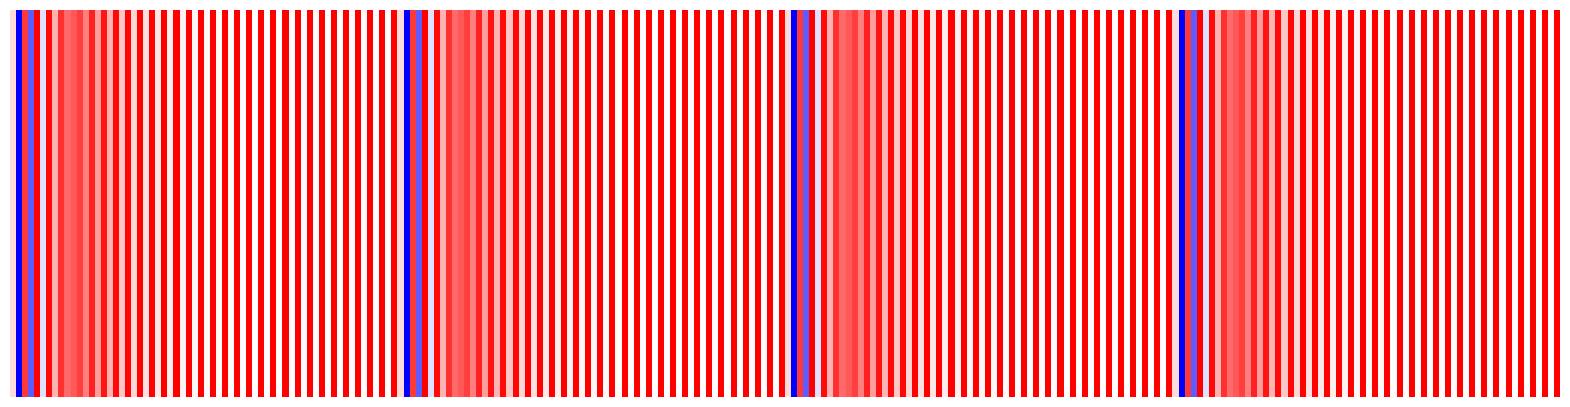

In [79]:
dim = 64
time_channels = 256
factor = torch.exp(torch.arange(0, dim, 2) * (- torch.log(torch.tensor(10000.0)) / dim))


t = torch.tensor(3)

if len(t.shape) == 0:
  t = t.unsqueeze(0)

t = t.unsqueeze(1) * factor

emb = torch.zeros(time_channels, dim)
emb[:, 0::2] = torch.sin(t)
emb[:, 1::2] = torch.cos(t)

print('embedding shape: ', emb.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

#ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')
ax.imshow(emb.detach().numpy().reshape(emb.shape[1], emb.shape[0]), cmap='bwr', interpolation='nearest')

#### labml implementation

embedding shape:  torch.Size([1, 64])
torch.Size([100, 64])


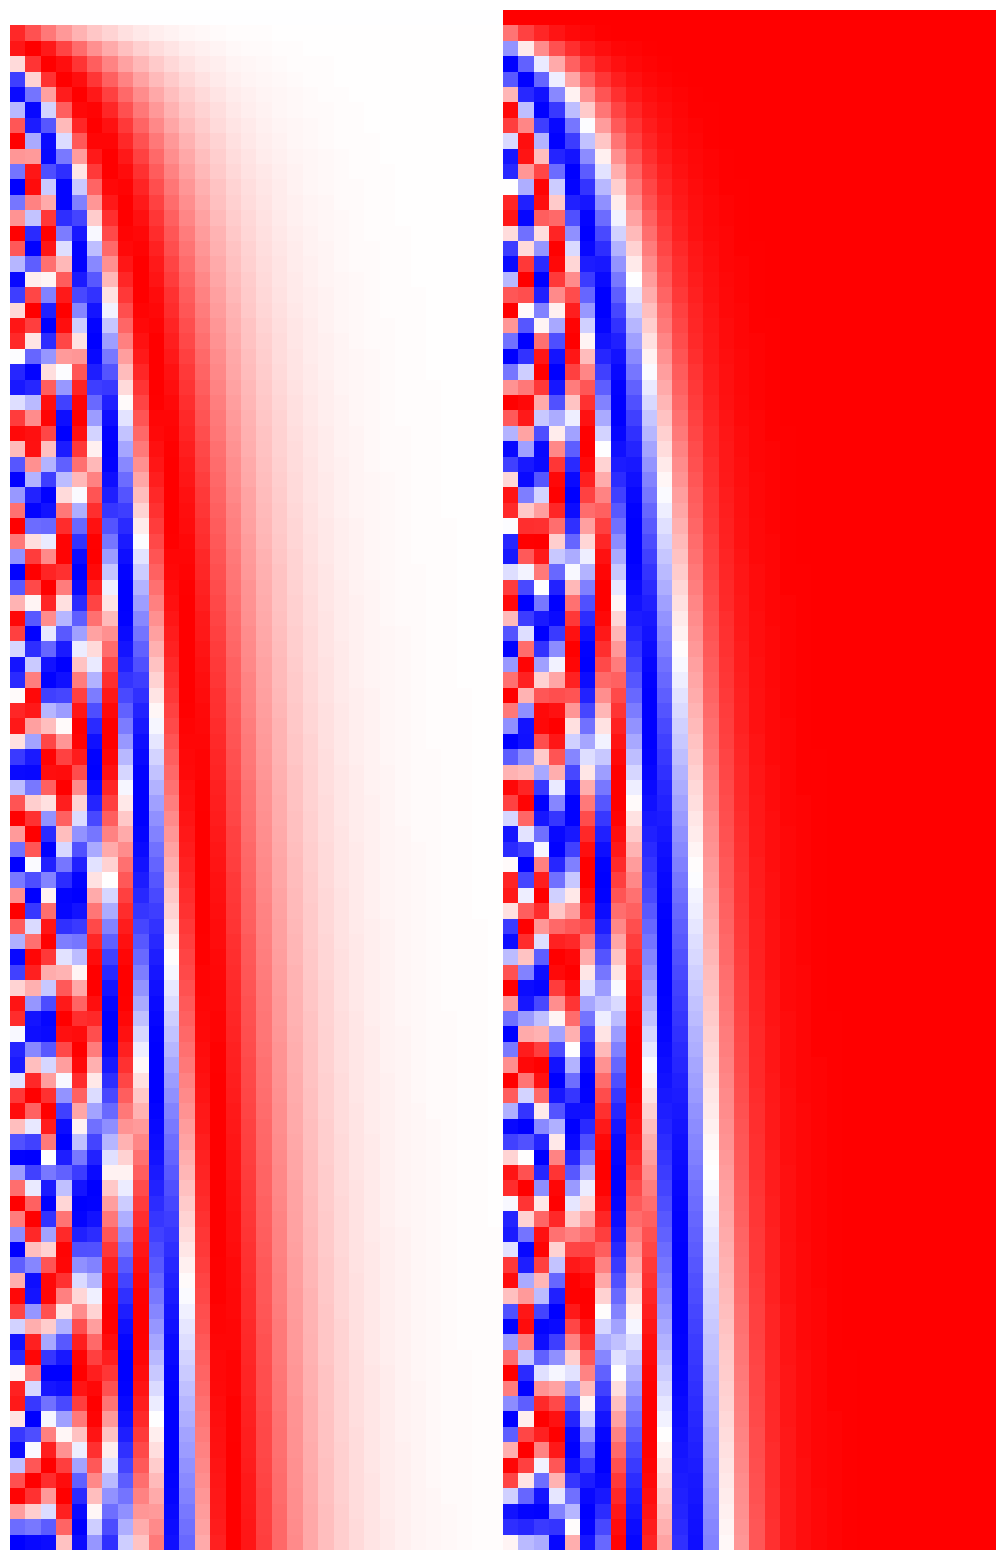

In [35]:
import math

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

half_dim = 32

emb_list = torch.empty((0, half_dim*2))

for i in range(100):
  t = torch.tensor([i])
  emb = math.log(10_000) / (half_dim - 1)
  emb = torch.exp(torch.arange(half_dim) * -emb)
  emb = t[:, None] * emb[None, :]
  emb = torch.cat((emb.sin(), emb.cos()), dim=1)
  emb_list = torch.cat((emb_list, emb), dim=0)

print('embedding shape: ', emb.shape)
print(emb_list.shape)
ax.imshow(emb_list.detach().numpy(), cmap='bwr', interpolation='nearest')

### Time Embedding Options

General Time Embeddings

In [ ]:
class General_TimeEmbedding(nn.Module):

    def __init__(self, dim=64, n_channels=256):
        super().__init__()

        self.dim = dim
        self.n_channels = n_channels

        # argument to sin/cos fn: t / 10000^(i / d) where i = 2k or 2k + 1 - https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
        self.factor = torch.exp(torch.arange(0, self.dim, 2) * (- math.log(10000.0) / self.dim))
        

    def forward(self):
        
        t = torch.arange(self.n_channels).unsqueeze(1) * self.factor
        emb = torch.zeros(self.n_channels, self.dim)
        emb[:, 0::2] = torch.sin(t)
        emb[:, 1::2] = torch.cos(t)

        return emb

In [ ]:
te = General_TimeEmbedding(dim=32, n_channels=256)
emb = te()
emb.shape

torch.Size([256, 32])

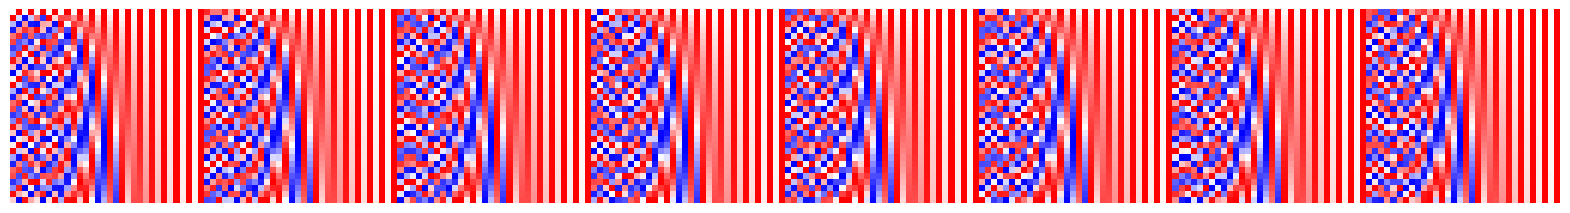

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()
ax.imshow(emb.detach().numpy().reshape(emb.size(1), emb.size(0)), cmap='bwr', interpolation='nearest')

Custom

With learnable parameters

In [ ]:
class TimeEmbedding(nn.Module):

    def __init__(self, dim=64, n_channels=256):
        super().__init__()

        self.dim = dim
        self.n_channels = n_channels

        # argument to sin/cos fn: t / 10000^(i / d) where i = 2k or 2k + 1 - https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
        self.factor =  torch.exp(torch.arange(0, self.dim, 2) * (- math.log(10000.0) / self.dim))
        
        m = self.n_channels // self.dim
        m = m // 2

        self.fc1 = nn.Linear(self.dim, self.dim * m)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.0)

        self.fc2 = nn.Linear(self.dim * m, self.n_channels)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, t):
        
        # t has to have shape (n_channels)
        t = t.unsqueeze(1) * self.factor
        emb = torch.zeros(self.n_channels, self.dim)
        emb[:, 0::2] = torch.sin(t)
        emb[:, 1::2] = torch.cos(t)

        emb = F.relu(self.fc1(emb))
        emb = self.fc2(emb)

        return emb

In [ ]:
t = torch.rand(256)
t.shape

torch.Size([256])

In [ ]:
te = TimeEmbedding(dim=32, n_channels=256)
emb = te(t)
emb.shape

torch.Size([256, 256])

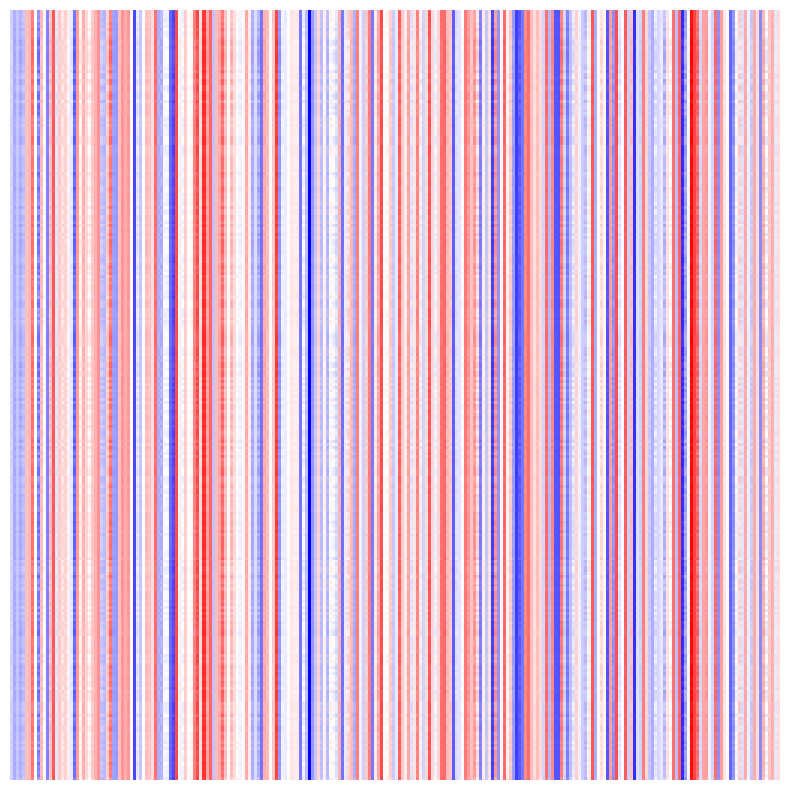

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()
ax.imshow(emb.detach().numpy(), cmap='bwr', interpolation='nearest')

Without learnable parameters

In [ ]:
class TimeEmbedding_2(nn.Module):

    def __init__(self, dim=64, n_channels=256):
        super().__init__()

        self.dim = dim
        self.n_channels = n_channels

        # argument to sin/cos fn: t / 10000^(i / d) where i = 2k or 2k + 1 - https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
        self.factor =  torch.exp(torch.arange(0, self.dim, 2) * (- math.log(10000.0) / self.dim))
        

    def forward(self, t):
        
        # t has to have shape (n_channels)
        t = t.unsqueeze(1) * self.factor
        emb = torch.zeros(self.n_channels, self.dim)
        emb[:, 0::2] = torch.sin(t)
        emb[:, 1::2] = torch.cos(t)

        return emb

In [ ]:
t = torch.rand(256)
t.shape

torch.Size([256])

In [ ]:
te = TimeEmbedding_2(dim=32, n_channels=256)
emb = te(t)
emb.shape

torch.Size([256, 32])

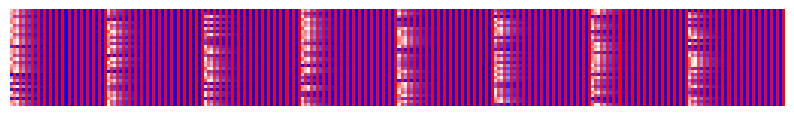

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()
ax.imshow(emb.detach().numpy().reshape(emb.size(1), emb.size(0)), cmap='bwr', interpolation='nearest')

Paper


In [ ]:
class Swish(nn.Module):
  def forward(self, x):
    return x*torch.sigmoid(x)

In [ ]:
class TimeEmbedding_paper(nn.Module):

  def __init__(self, time_channels):
    super().__init__()

    self.time_channels = time_channels

    self.hidden1 = nn.Linear(self.time_channels // 4, self.time_channels)

    self.act = Swish()
    
    self.hidden2 = nn.Linear(self.time_channels, self.time_channels)

  def forward(self, t):

    half_dim = self.time_channels // 8
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)

    emb = self.hidden1(emb)
    emb = self.act(emb)
    emb = self.hidden2(emb)
    return emb

In [ ]:
time_channels = 256
t = torch.rand(time_channels)
te = TimeEmbedding_paper(time_channels)
emb = te(t)
emb.shape

torch.Size([256, 256])

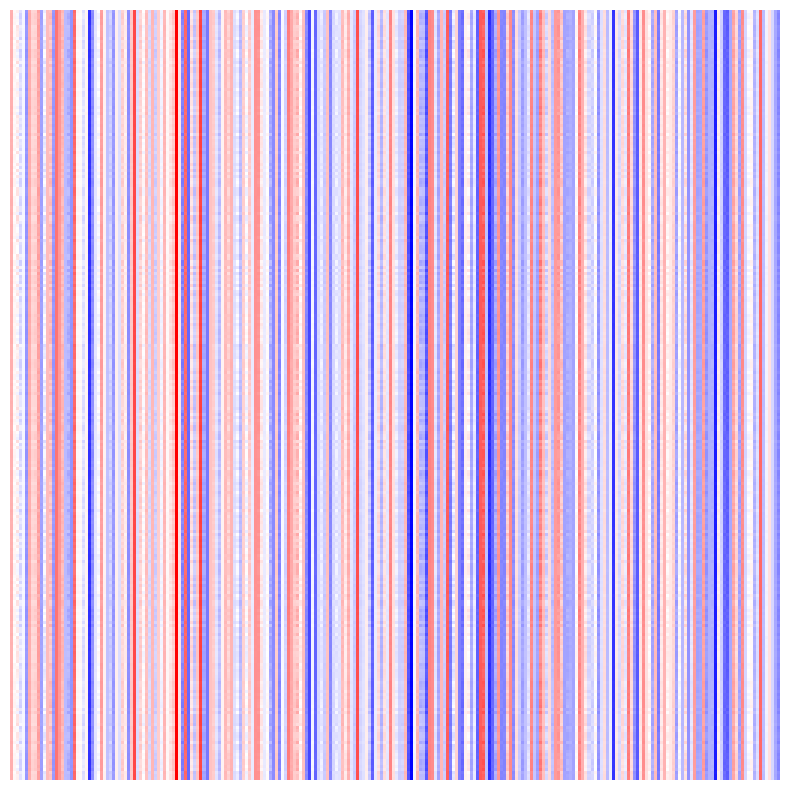

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()
ax.imshow(emb.detach().numpy(), cmap='bwr', interpolation='nearest')

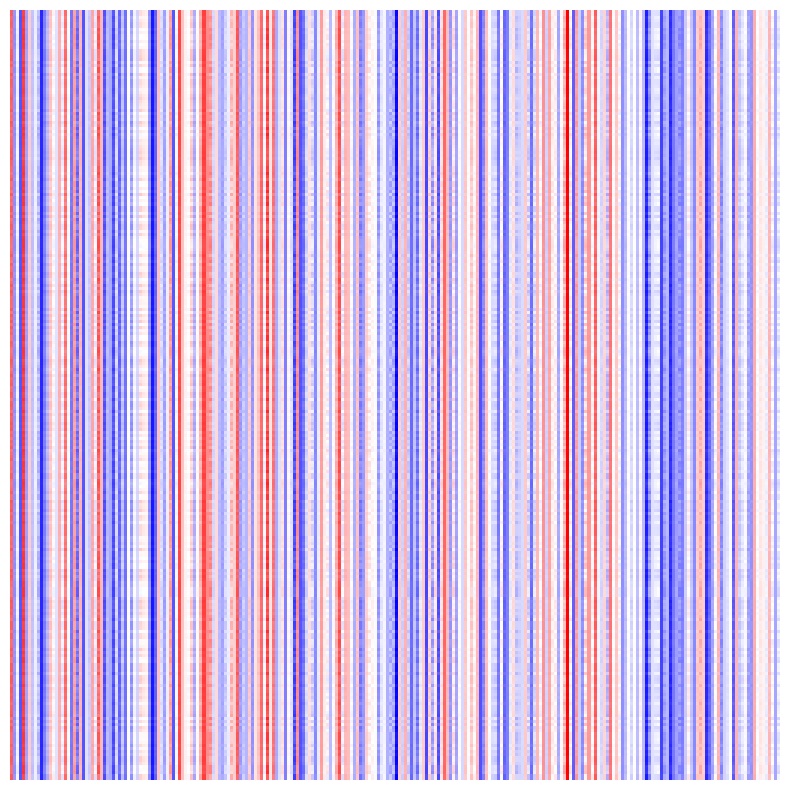

In [ ]:
'''
TimeEmbedding2, but with TanH activation
'''
#fig, ax = plt.subplots(figsize=(10,10))
#ax.set_axis_off()
#ax.imshow(emb.detach().numpy(), cmap='bwr', interpolation='nearest')